# Big Blue Bus speeds using `vp_usable_with_dwell`

## Alignments
* Align nearest neighbor and interpolation steps
* Dwell times are factored in
* Interpolation of stop arrival looks at the previous `moving_timestamp_local` which is after the bus gets moving again, and this stop's `location_timestamp_local`, which is the beginning of the bus's dwelling at a stop.

## Speed
* Retain how speed is calculated - even remove filters (in averaging, speeds over 80 mph are filtered out) to show full distribution
* In the full distribution, we'll keep extra high speeds in, and decide on where are high/low filters should be

In [1]:
import folium
import geopandas as gpd
import pandas as pd

from segment_speed_utils.project_vars import SEGMENT_GCS
from shared_utils import rt_dates, rt_utils

analysis_date = rt_dates.DATES["apr2024"]

In [2]:
speeds = pd.read_parquet(
    f"{SEGMENT_GCS}bbb_speeds_by_trip_{analysis_date}.parquet"
)
   
segment_speeds = gpd.read_parquet(
    f"{SEGMENT_GCS}bbb_segment_speeds_gdf_{analysis_date}.parquet"
)

In [3]:
speeds[speeds.speed_mph <= 80].speed_mph.describe()

count    32161.000000
mean        14.200993
std          8.277521
min          0.033953
25%          8.890265
50%         12.699928
75%         17.480291
max         79.641062
Name: speed_mph, dtype: float64

<AxesSubplot:>

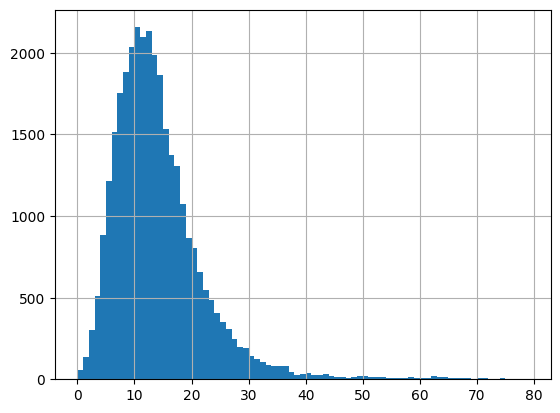

In [4]:
speeds.speed_mph.hist(bins=range(0, 80, 1))

In [5]:
segment_speeds.p20_mph.describe()

count    67701.000000
mean         6.209578
std          3.949743
min          0.050000
25%          3.700000
50%          5.610000
75%          7.790000
max         65.790000
Name: p20_mph, dtype: float64

In [6]:
segment_speeds.p50_mph.describe()

count    67701.000000
mean         6.294138
std          3.925301
min          0.070000
25%          3.760000
50%          5.690000
75%          7.850000
max         65.790000
Name: p50_mph, dtype: float64

In [7]:
segment_speeds.p80_mph.describe()

count    67701.000000
mean         6.378770
std          3.903607
min          0.090000
25%          3.910000
50%          5.760000
75%          7.900000
max         65.790000
Name: p80_mph, dtype: float64

In [8]:
def filter_specific_stops(
    speeds, 
    stop_pair: str
):
    """
    Pull out a specific stop (using stop_pair)
    and show the distribution of speeds.
    First table shows time-of-day distribution (AM Peak)
    and second table shows how certain time-of-day aggregations
    get rolled into peak vs offpeak.
    """
    
    speeds_subset = speeds[
        speeds.stop_pair == stop_pair].sort_values("speed_mph")
    
    list_of_speeds = speeds_subset.groupby(
        ["time_of_day", "peak_offpeak", 
         "stop_pair",
         "stop_sequence", "stop_sequence1"]).agg(
        {"speed_mph": lambda x: list(round(x, 2))}
    ).reset_index()


    list_of_speeds2 = speeds_subset.groupby(
        ["peak_offpeak", 
         "stop_pair",
         "stop_sequence", "stop_sequence1"]).agg(
        {"speed_mph": lambda x: list(round(x, 2))}
    ).reset_index()

    with pd.option_context(
        'display.max_rows', None, 
        'display.max_columns', None,
        # bump the last column so we can print out all the values in the
        # distribution of speeds
        'display.max_colwidth', None
    ):  # more options can be specified also
        display(list_of_speeds) 
        display(list_of_speeds2)


In [9]:
# Find some stops that show up as green on the 20th percentile 
# either AM Peak, Midday, or PM Peak
find_me = {
    "Olympic & Veteran to Olympic and Westwood": "688__59",
    "some_other_stop": "1530__1531",
    "Barrington & La Grange to Barrington & Olympic (Sawtelle)":"1392__1393"
}

In [10]:
filter_specific_stops(speeds, "688__59")

,time_of_day,peak_offpeak,stop_pair,stop_sequence,stop_sequence1,speed_mph
0,AM Peak,peak,688__59,26,26.0,"[16.85, 25.57]"
1,Midday,offpeak,688__59,26,26.0,"[13.01, 13.99, 17.24, 24.71]"
2,PM Peak,peak,688__59,26,26.0,"[7.49, 10.3, 14.83, 26.48]"


,peak_offpeak,stop_pair,stop_sequence,stop_sequence1,speed_mph
0,offpeak,688__59,26,26.0,"[13.01, 13.99, 17.24, 24.71]"
1,peak,688__59,26,26.0,"[7.49, 10.3, 14.83, 16.85, 25.57, 26.48]"


In [11]:
filter_specific_stops(speeds, "1530__1531")

,time_of_day,peak_offpeak,stop_pair,stop_sequence,stop_sequence1,speed_mph
0,AM Peak,peak,1530__1531,20,20.0,"[4.95, 8.37, 15.87, 17.72, 18.14, 22.41, 25.39]"
1,Early AM,offpeak,1530__1531,20,20.0,"[15.87, 18.58]"
2,Evening,offpeak,1530__1531,20,20.0,"[6.0, 18.58]"
3,Midday,offpeak,1530__1531,20,20.0,"[10.73, 11.54, 13.6, 13.6, 14.11, 14.65, 14.65, 15.55, 21.16, 24.57, 26.27, 29.3, 29.3, 58.6]"
4,PM Peak,peak,1530__1531,20,20.0,"[9.4, 9.64, 10.16, 10.29, 13.6, 13.85, 15.24, 15.87, 16.21, 16.93, 20.59, 21.77]"


,peak_offpeak,stop_pair,stop_sequence,stop_sequence1,speed_mph
0,offpeak,1530__1531,20,20.0,"[6.0, 10.73, 11.54, 13.6, 13.6, 14.11, 14.65, 14.65, 15.55, 15.87, 18.58, 18.58, 21.16, 24.57, 26.27, 29.3, 29.3, 58.6]"
1,peak,1530__1531,20,20.0,"[4.95, 8.37, 9.4, 9.64, 10.16, 10.29, 13.6, 13.85, 15.24, 15.87, 15.87, 16.21, 16.93, 17.72, 18.14, 20.59, 21.77, 22.41, 25.39]"


In [12]:
filter_specific_stops(speeds, "1392__1393")

,time_of_day,peak_offpeak,stop_pair,stop_sequence,stop_sequence1,speed_mph
0,AM Peak,peak,1392__1393,12,12.0,"[2.69, 18.21, 29.68, inf]"
1,Midday,offpeak,1392__1393,12,12.0,"[6.21, 13.13, 15.41, 19.08, 19.54, 22.89]"
2,PM Peak,peak,1392__1393,12,12.0,"[2.88, 8.09, 12.52]"


,peak_offpeak,stop_pair,stop_sequence,stop_sequence1,speed_mph
0,offpeak,1392__1393,12,12.0,"[6.21, 13.13, 15.41, 19.08, 19.54, 22.89]"
1,peak,1392__1393,12,12.0,"[2.69, 2.88, 8.09, 12.52, 18.21, 29.68, inf]"
